In [2]:
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import os
import codecs
import numpy.random as nr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.precision', 10)
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import plotly_express as px

#for l2 normalization
import sklearn.preprocessing



import re
import spacy

#initiate spacy with english language
#nlp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
from pattern.en import suggest
import nltk

#phrase modeling
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases , Phraser
import string
from nltk import pos_tag

# NLTK Stop words
from nltk.corpus import stopwords

from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from gensim.models.word2vec import Text8Corpus
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim
from gensim import corpora
from gensim.corpora import Dictionary, MmCorpus

#clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

#for creating wordcloud
from wordcloud import WordCloud, STOPWORDS

#lines below let allow multiple results from a line of code to be shown e.g. df.head() + df.columns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import fasttext
import fasttext 
import sister

#stopwords parser here, you can add any in that you want
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['microsoft', 'teams'])

import umap.umap_ as umap
import hdbscan

C:\Users\fulto\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fulto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [217]:
os.chdir('C:\\Users\\fulto\\Desktop\\Driver Analysis\\Teams')

In [218]:
bing = pd.read_csv('teams_bing_queries_since_Jan_2020.csv')

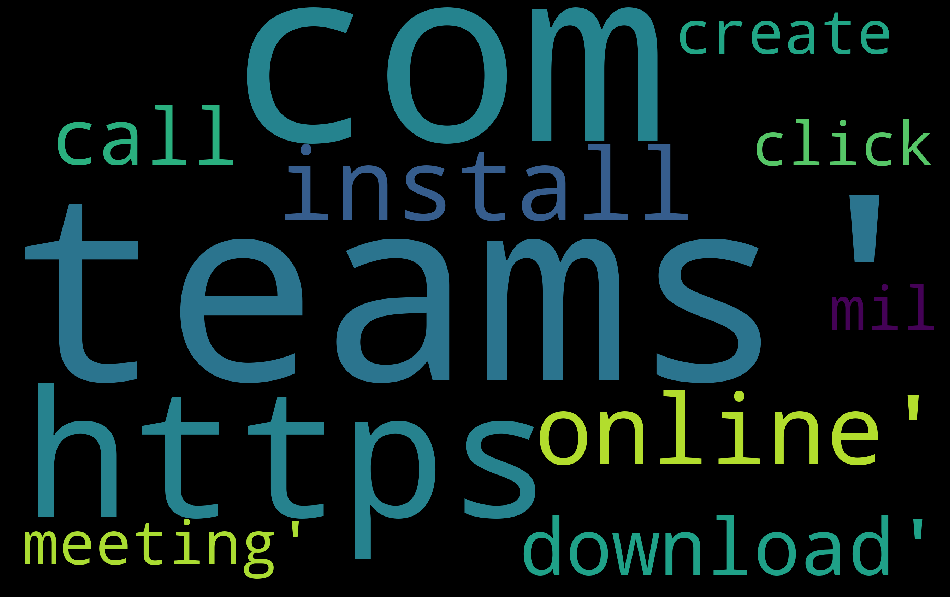

In [19]:
text = bing.Feedback_Verbatim.values
wordcloud = WordCloud(width = 2650, height = 1650, background_color = 'black', stopwords = stop_words).generate(str(text))
fig = plt.figure(figsize = (13, 10), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show();

In [285]:
def scrub_text(df, text_column, trigrams = False):
    
    '''
    
    This function takes a column of text and cleans it, while also performing phrase modeling on the column
    
    '''
    
    #get all reviews into list
    data = list(df[text_column].values)


    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
    data_words = list(sent_to_words(data))  
    
    # Build the bigram and trigram models
    #the min_count determines if the model ignores all words and bigrams with total collected count lower than this value.
    bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], min_count = 1, threshold=100)

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    #lemmatizing produces an actual english word as a root as opposed to stemming which may not be a real word
    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    
    if trigrams == True:
   
        # Form trigrams
        data_words_trigrams = make_trigrams(data_words_nostops)

        # Do lemmatization keeping only noun, adj, vb, adv
        data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    else:
        
        data_words_bigrams = make_bigrams(data_words_nostops)
        
        data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    #take all of the lemmatized and trigrammed reviews and dump them into a new column
    df['scrubbed_text'] = [x for x in data_lemmatized]
        
    #convert column of lists to strings
    df['scrubbed_text'] = df['scrubbed_text'].apply(', '.join)

    #remove commas from strings
    df['scrubbed_text'] = df['scrubbed_text'].str.replace(',','')

    return df

In [21]:
#run text through scrubber
bing = scrub_text(bing, 'Feedback_Verbatim', trigrams = False)

In [29]:
#heres an example of a phrase thats been glued together, 'common_error' is now treated as one token
bing[bing['scrubbed_text'].str.contains('_')].head(1)

Feedback_Verbatim    Feedback_DateTime Feedback_App  \
31  common errors in microsoft teams  2020-01-31 12:00:00  Teams         

   Feedback_SurveyName Feedback_Platform Feedback_Type Feedback_UserType  \
31  Bing                Bing              BingSearch    General            

   scrubbed_text  
31  common_error

In [30]:
bing.to_csv('scrubbed_bing_queries.csv', index = False)

In [48]:
scrubbed = pd.read_csv('scrubbed_bing_queries.csv')

In [49]:
scrubbed.isna().sum()

Feedback_Verbatim      0    
Feedback_DateTime      0    
Feedback_App           0    
Feedback_SurveyName    0    
Feedback_Platform      0    
Feedback_Type          0    
Feedback_UserType      0    
scrubbed_text          35936
dtype: int64

In [25]:
scrubbed.head()

Feedback_Verbatim    Feedback_DateTime  \
0  install microsoft teams                        2020-01-31 12:00:00   
1  teams.microsoft.com online                     2020-01-31 12:00:00   
2  teams microsoft download                       2020-01-31 12:00:00   
3  download microsoft teams app for desktop       2020-01-31 12:00:00   
4  how to stop microsoft teams from auto opening  2020-01-31 12:00:00   

  Feedback_App Feedback_SurveyName Feedback_Platform Feedback_Type  \
0  Teams        Bing                Bing              BingSearch     
1  Teams        Bing                Bing              BingSearch     
2  Teams        Bing                Bing              BingSearch     
3  Teams        Bing                Bing              BingSearch     
4  Teams        Bing                Bing              BingSearch     

  Feedback_UserType      scrubbed_text  
0  General           install            
1  General           com online         
2  General           NaN                
3  General           app desktop        
4  General           stop auto opening

In [31]:
#drop missing cells (those that contained microsoft teams or one of those words only)
bing = bing.dropna(axis = 0, subset = ['scrubbed_text']).reset_index(drop = True)

In [32]:
#create embeddings for each query
bert_embedding = sister.BertEmbedding(lang="en")

#using BERT to create embeddings
vectors = [bert_embedding(query) for query in bing.scrubbed_text]

#convert to df
bing_vectors = pd.DataFrame(vectors)

#normalizing word vectors to improve similarity performance https://stats.stackexchange.com/questions/177905/should-i-normalize-word2vecs-word-vectors-before-using-them
# research says that using the l2 norm improves model performance more than any other normalization method https://www.groundai.com/project/improving-bert-fine-tuning-wit
#h-embedding-normalization/1
#so we are using the l2 norm here for unit norm transformation
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html
normed_bing_vectors = sklearn.preprocessing.normalize(bing_vectors, norm = 'l2', axis = 1)

#make the actual queries the index of each embedding
normed_bing_vectors = pd.DataFrame(normed_bing_vectors)
normed_bing_vectors.index = [x for x in bing['Feedback_Verbatim']]

#send vectors to csv in case the kernel dies
normed_bing_vectors.to_csv('bing_vectors.csv')

In [3]:
bing = pd.read_csv('bing_vectors.csv', index_col = 0)

In [16]:
bing = pd.read_csv('bing_vectors.csv')

In [18]:
bing.rename(columns ={'Unnamed: 0':'query'}, inplace=True)

In [5]:
# Create UMAP reduce
reducer = umap.UMAP(n_neighbors=60, n_components = 3, min_dist = 0)
reduced_bing_vectors = reducer.fit_transform(bing)

In [7]:
pd.DataFrame(reduced_bing_vectors).to_csv('pre_clustering_reduced_bing_vectors.csv')

In [63]:
reduced_bing_vectors = pd.read_csv('pre_clustering_reduced_bing_vectors.csv').drop('Unnamed: 0', axis = 1)

In [55]:
reduced_bing_vectors.head()

0          1          2
0  30.866621  9.5091830  8.7188050
1 -11.944756  4.6597220  2.2510730
2  13.973702  2.6014721  3.5440943
3 -9.156345  -6.1814460 -2.2882104
4 -20.415802  5.7526810  7.1407866

In [14]:
#use HDBSCAN for clustering the embeddings, then reduce to 3d then plot
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=1500, min_samples = 1, cluster_selection_method = 'leaf').fit_predict(reduced_bing_vectors)

In [287]:
bing_vectors_2= reduced_bing_vectors.iloc[:, :3]

In [300]:
cluster_labels_2 = hdbscan.HDBSCAN(min_cluster_size=2000, min_samples = 3, cluster_selection_method = 'leaf').fit_predict(bing_vectors_2)

In [301]:
pd.DataFrame(cluster_labels_2).iloc[:,0].value_counts()

 3     35936
-1     20928
 1     7184 
 5     6528 
 10    5600 
 4     5504 
 11    5424 
 0     4144 
 8     4080 
 2     3376 
 9     2768 
 6     2768 
 7     2496 
Name: 0, dtype: int64

In [305]:
bing_vectors_2['cluster'] = [x for x in cluster_labels_2]

bing_vectors_2['query'] = [x for x in bing['query']]

bing_vectors_2['scrubbed_query'] = [x for x in scrubbed['scrubbed_text']]

In [49]:
36908/106000

0.348188679245283

In [15]:
pd.DataFrame(cluster_labels).iloc[:,0].value_counts()

-1     33132
 23    10390
 16    4256 
 0     4144 
 4     4000 
 17    3872 
 3     3792 
 20    3776 
 14    3744 
 12    3744 
 1     3376 
 11    3344 
 8     2656 
 15    2496 
 6     2176 
 21    2025 
 2     1952 
 22    1909 
 9     1872 
 7     1872 
 18    1760 
 13    1648 
 19    1648 
 5     1584 
 10    1568 
Name: 0, dtype: int64

In [64]:
reduced_bing_vectors['cluster'] = [x for x in cluster_labels]

reduced_bing_vectors['query'] = [x for x in bing['query']]

reduced_bing_vectors['scrubbed_query'] = [x for x in scrubbed['scrubbed_text']]

In [59]:
reduced_bing_vectors.dropna(inplace = True)

In [62]:
reduced_bing_vectors.cluster.value_counts()

-1     11520
 16    4256 
 0     4144 
 4     4000 
 17    3872 
 3     3792 
 20    3776 
 14    3744 
 12    3744 
 1     3376 
 11    3344 
 8     2656 
 15    2496 
 6     2176 
 2     1952 
 9     1872 
 7     1872 
 18    1760 
 13    1648 
 19    1648 
 5     1584 
 10    1568 
Name: cluster, dtype: int64

In [148]:
bing_vectors_2 = pd.read_csv('final_teams_bing_clustering_results.csv')

In [220]:
#add in date to vector df
bing_vectors_2['Feedback_DateTime'] = [x for x in bing['Feedback_DateTime']]

In [221]:
bing_vectors_2.head()

0          1          2  cluster  \
0  30.866621  9.5091830  8.7188050  1         
1 -11.944756  4.6597220  2.2510730  9         
2  13.973702  2.6014721  3.5440943  3         
3 -9.156345  -6.1814460 -2.2882104  7         
4 -20.415802  5.7526810  7.1407866  5         

                                           query     scrubbed_query  \
0  install microsoft teams                        install             
1  teams.microsoft.com online                     com online          
2  teams microsoft download                       NaN                 
3  download microsoft teams app for desktop       app desktop         
4  how to stop microsoft teams from auto opening  stop auto opening   

         cluster_name    Feedback_DateTime  
0  Free Install        2020-01-31 12:00:00  
1  Video Conferencing  2020-01-31 12:00:00  
2  3                   2020-01-31 12:00:00  
3  Not Working         2020-01-31 12:00:00  
4  Background Upload   2020-01-31 12:00:00

In [113]:
import collections
import nltk
nltk.download('punkt')

def cluster_name(cluster):
    
    counts = collections.Counter()
    name_df =bing_vectors_2.copy()

    name_df['query'] = bing_vectors_2['query'].str.replace('microsoft|teams|how|to|%|www|https|.com|:', '')
    for sent in name_df[name_df['cluster'] == cluster]['query']:
        words = nltk.word_tokenize(sent)
        counts.update(nltk.bigrams(words))
    return counts.most_common(5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fulto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [157]:
STOPWORDS.add('www')
STOPWORDS.add('microsoftteam')
STOPWORDS.add('https')
STOPWORDS.add('com')

In [289]:
def wordcloud(cluster):
    df = bing_vectors_2.copy()
    df['scrubbed_query'] = df['scrubbed_query'].str.replace('microsoft|teams|how|to|%|www|https|.com|:', '')
    df = df[df['cluster'] == cluster]
    STOPWORDS.add('microsoft')
    STOPWORDS.add('teams')
    wordcloud=WordCloud(width=2650,height=1650, stopwords = STOPWORDS, collocations = True).generate(' '.join(map(str, df['query']))) 
    fig = plt.figure(figsize = (13, 10), facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show();

In [293]:
a[a['query'].str.contains('not working')]

0          1          2  cluster  \
1073   -16.4924950 -6.4148164  2.7700236  7         
1090   -15.8453880 -1.3173693 -7.6835370  7         
1685   -16.5336500 -6.3734130  2.8115025  7         
1961   -15.8455620 -1.3173302 -7.6836934  7         
2225   -16.4934880 -6.4134197  2.7713660  7         
2286   -16.4937230 -6.4136870  2.7709694  7         
2325   -16.4963840 -6.4107360  2.7739818  7         
2906   -16.4944460 -6.4126406  2.7719762  7         
3871   -16.4973260 -6.4097285  2.7747690  7         
4614   -16.4956380 -6.4116135  2.7734640  7         
4809   -15.8458310 -1.3172765 -7.6837660  7         
5152   -16.4960040 -6.4111750  2.7738807  7         
5516   -16.4965400 -6.4106307  2.7737877  7         
6153   -15.8458730 -1.3171395 -7.6836920  7         
7744   -16.4939820 -6.4134020  2.7712266  7         
7761   -15.8458630 -1.3171915 -7.6837363  7         
8356   -16.4942780 -6.4128757  2.7715380  7         
8632   -15.8458840 -1.3172171 -7.6835040  7         
8896   -16.4953780 -6.4117670  2.7727604  7         
8957   -16.5329280 -6.3741665  2.8102367  7         
8996   -16.5199380 -6.3866140  2.7975123  7         
9577   -16.4946350 -6.4125270  2.7723029  7         
10542  -16.4956720 -6.4113580  2.7730346  7         
11285  -16.4935570 -6.4135756  2.7707825  7         
11480  -15.8459310 -1.3171014 -7.6835040  7         
11823  -16.4948600 -6.4126020  2.7716281  7         
12187  -16.4969620 -6.4099960  2.7745469  7         
12824  -15.8457090 -1.3172666 -7.6836433  7         
14415  -16.4957850 -6.4104023  2.7736843  7         
14432  -15.8460040 -1.3170020 -7.6835284  7         
15027  -16.4985430 -6.4082317  2.7765343  7         
15303  -15.8461880 -1.3168603 -7.6834960  7         
15567  -16.4953460 -6.4115520  2.7730220  7         
15628  -16.4950710 -6.4103136  2.7734675  7         
15667  -16.4956990 -6.4107757  2.7734761  7         
16248  -16.4967200 -6.4095373  2.7746763  7         
17213  -16.4960380 -6.4100310  2.7740781  7         
17956  -16.4807510 -6.4218980  2.7628393  7         
18151  -15.8462330 -1.3169148 -7.6834410  7         
18494  -16.5166930 -6.3894577  2.7948754  7         
18858  -16.5301650 -6.3757790  2.8088020  7         
19495  -15.8460480 -1.3169500 -7.6836395  7         
21086  -16.5245690 -6.3829450  2.8032110  7         
21103  -15.8459250 -1.3171873 -7.6841530  7         
21698  -16.4974140 -6.4092445  2.7756457  7         
21974  -15.8458460 -1.3172896 -7.6843720  7         
22238  -16.4906480 -6.4157457  2.7690630  7         
22299  -16.4988840 -6.4072633  2.7772574  7         
22338  -16.4964470 -6.4098620  2.7747853  7         
22919  -16.4956780 -6.4104790  2.7738270  7         
23884  -16.4931500 -6.4136270  2.7700183  7         
24627  -16.4955100 -6.4106330  2.7736852  7         
24822  -15.8459570 -1.3172892 -7.6845100  7         
25165  -16.4966370 -6.4095770  2.7749352  7         
25529  -16.4973850 -6.4089193  2.7756445  7         
26166  -15.8460290 -1.3172908 -7.6846304  7         
27757  -16.4961010 -6.4100320  2.7743450  7         
27774  -15.8461840 -1.3170708 -7.6842847  7         
28369  -16.4961400 -6.4101043  2.7745497  7         
28645  -15.8461790 -1.3169744 -7.6841760  7         
28909  -16.4964960 -6.4097056  2.7747657  7         
28970  -16.4964160 -6.4098340  2.7746391  7         
29009  -16.4960020 -6.4102488  2.7741995  7         
29590  -16.4959350 -6.4102630  2.7741720  7         
30555  -16.5350570 -6.3710847  2.8131993  7         
31298  -16.4957080 -6.4104896  2.7739615  7         
31493  -15.8461610 -1.3170900 -7.6842837  7         
31836  -16.5002520 -6.4063910  2.7780936  7         
32200  -16.4987030 -6.4076010  2.7765560  7         
32837  -15.8462890 -1.3168759 -7.6839480  7         
34428  -16.4966260 -6.4097376  2.7743404  7         
34445  -15.8463790 -1.3166286 -7.6835810  7         
35040  -16.4941940 -6.4119380  2.7721488  7         
35316  -15.8462500 -1.3166426 -7.6832867  7         
35580  -16.4960670 -6.4101686  2.7741349  

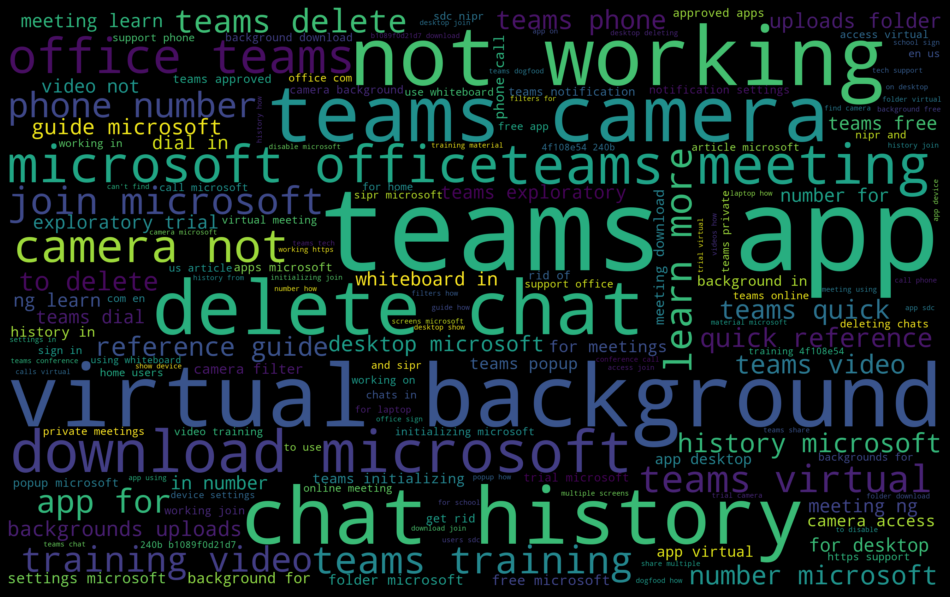

In [290]:
wordcloud(7)

In [326]:
bing_vectors_2[bing_vectors_2['query'].str.contains('error')].head()

0          1           2  cluster  \
31  -1.8138610   5.4153104  4.5963316   8         
230  13.7374525  1.6679319  2.5852268   3         
394  13.6508700  1.9644312 -17.3655990  2         
458  13.7142930  1.5784454  4.3878384   3         
621  12.8515970  2.0400293  3.8754807   3         

                                query scrubbed_query  
31   common errors in microsoft teams  common_error   
230  microsoft teams error code - 4c7  NaN            
394  microsoft teams error 503         error          
458  microsoft teams error code 503    NaN            
621  error code 503 microsoft teams    NaN

In [161]:
bing_vectors_2[bing_vectors_2['query'].str.contains('sign')].head()

0            1           2  cluster  \
30   27.804980 -0.27031870   17.9988250  0         
57  -8.777636   2.99953990  -10.1469400 -1         
66  -12.592861  18.09808200 -1.8571713   10        
162  27.819805 -0.27215886   18.0232160  0         
182  27.840750 -0.24692293   18.0372300  0         

                              query scrubbed_query    cluster_name  
30   teams microsoft sign in         sign           sign in         
57   microsoft teams online sign in  online sign    noise           
66   microsoft teams web sign in     web sign       add background  
162  microsoft teams sign in         sign           sign in         
182  sign in to microsoft teams      sign           sign in

In [118]:
cluster_name(0)

[(('sign', 'in'), 704),
 (('sign', 'up'), 224),
 (('set', 'up'), 208),
 (('#', 'TAB'), 160),
 (('TAB', '#'), 160)]

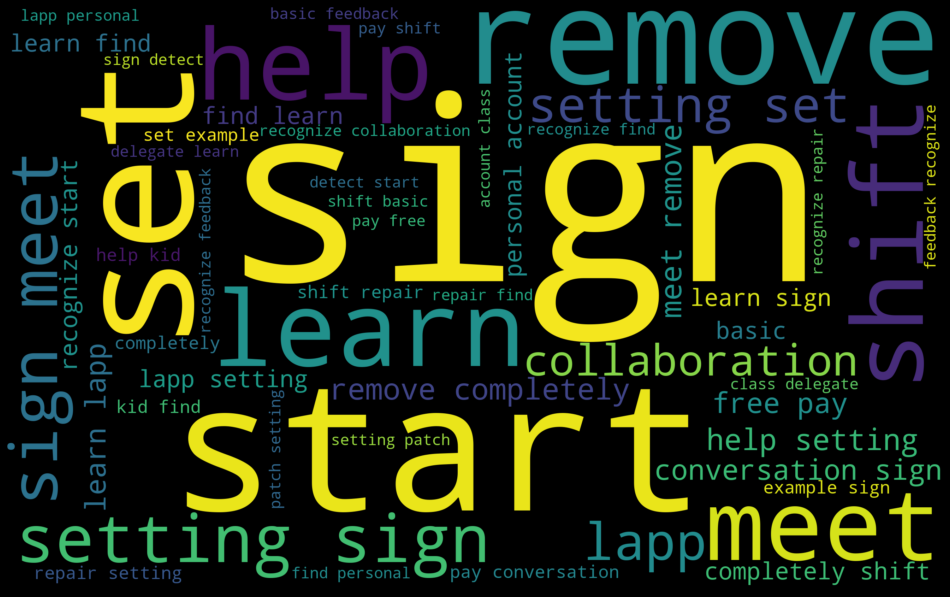

In [108]:
wordcloud(0)

In [117]:
cluster_name(1)

[(('cusm', 'background'), 288),
 (('screen', 'share'), 272),
 (('for', 'free'), 224),
 (('is', 'free'), 176),
 (('join', 'meeting'), 176)]

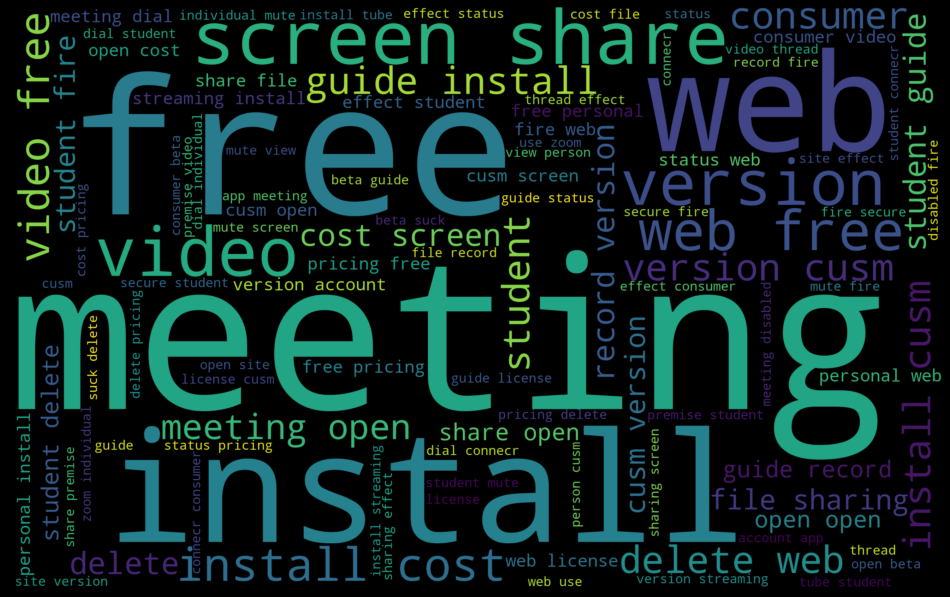

In [119]:
wordcloud(1)

In [120]:
cluster_name(2)

[(('camera', 'sideways'), 224),
 (('add', 'outlook'), 208),
 (('sideways', 'in'), 208),
 (('why', 'is'), 192),
 (('is', 'my'), 192)]

In [213]:
bing_vectors_2[bing_vectors_2['query'].str.contains('sideways')].head(20)

0           1           2  cluster  \
758   15.501699 -18.4128100  0.23708552  2         
1046  15.518617 -18.4025340  0.22121991  2         
1181  15.510915 -18.4176390  0.22831534  2         
1355  15.536496 -18.3848320  0.20234786  2         
1462  15.514424 -18.4106860  0.22342253  2         
1474  15.512151 -18.4152810  0.22685783  2         
1537  15.510578 -18.4150430  0.22841454  2         
1811  15.508049 -18.4095500  0.22971699  2         
1828  15.513482 -18.4081130  0.22508660  2         
1913  15.475080 -18.4524630  0.26444320  2         
1932  15.584866 -18.4461780  0.15435527  2         
2029  15.512815 -18.4133470  0.22536552  2         
2045  14.203865  1.1057235   3.25592400  3         
2072  13.676930  2.2300067   4.35060740  3         
2111  15.527622 -18.3909630  0.21247749  2         
2158  15.471227 -18.4550760  0.26796174  2         
2273  15.510569 -18.4186500  0.22763565  2         
2327  15.513824 -18.4124300  0.22539430  2         
2328  15.561975 -18.3560730  0.17674156  2         
2425  15.535886 -18.3891580  0.20223892  2         

                                              query scrubbed_query  \
758   microsoft teams camera sideways                sideways        
1046  microsoft teams video sideways                 sideways        
1181  camera sideways in microsoft teams             sideways        
1355  why is my camera sideways on microsoft teams   sideways        
1462  why is my webcam sideways on microsoft teams   sideways        
1474  camera is sideways on microsoft teams          sideways        
1537  microsoft teams camera sideways                sideways        
1811  camera sideways in microsoft teams             sideways        
1828  camera is sideways on microsoft teams          sideways        
1913  why is my camera sideways in microsoft teams   sideways        
1932  why is my camera sideways on microsoft teams   sideways        
2029  microsoft teams video is sideways              sideways        
2045  microsoft teams video sideways fix             NaN             
2072  microsoft teams sideways video                 NaN             
2111  why am i sideways in microsoft teams           sideways        
2158  microsoft teams video sideways                 sideways        
2273  why is my webcam sideways on microsoft teams   sideways        
2327  why is my microsoft teams video chat sideways  sideways        
2328  why is my video sideways on microsoft teams    sideways        
2425  why is my video sideways in microsoft teams    sideways        

         cluster_name  
758   Camera Sideways  
1046  Camera Sideways  
1181  Camera Sideways  
1355  Camera Sideways  
1462  Camera Sideways  
1474  Camera Sideways  
1537  Camera Sideways  
1811  Camera Sideways  
1828  Camera Sideways  
1913  Camera Sideways  
1932  Camera Sideways  
2029  Camera Sideways  
2045  3                
2072  3                
2111  Camera Sideways  
2158  Camera Sideways  
2273  Camera Sideways  
2327  Camera Sideways  
2328  Camera Sideways  
2425  Camera Sideways

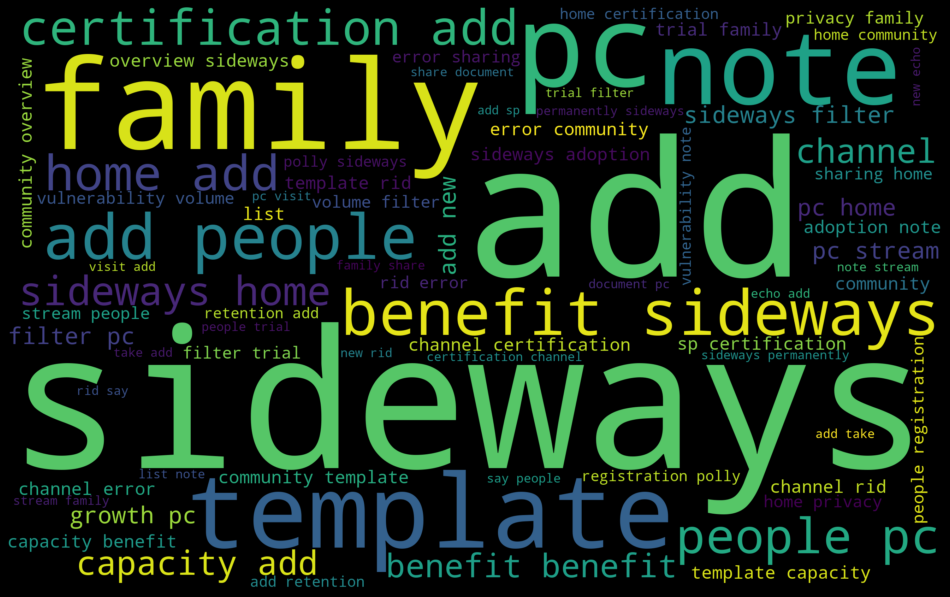

In [121]:
wordcloud(2)

In [122]:
cluster_name(4)

[(('windows', '10'), 816),
 (('download', 'for'), 560),
 (('for', 'windows'), 512),
 (('download', 'windows'), 304),
 (('not', 'working'), 240)]

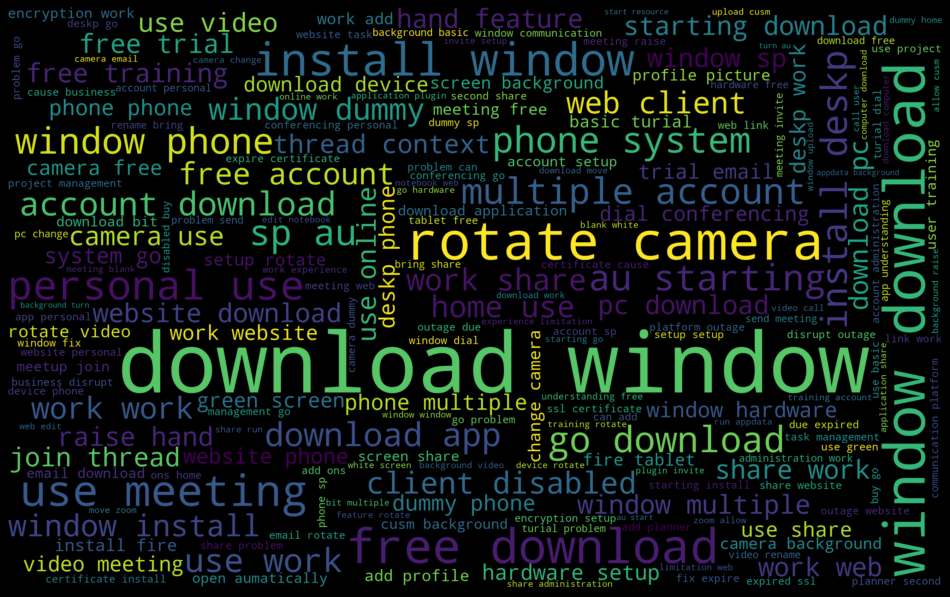

In [123]:
wordcloud(4)

In [124]:
cluster_name(5)

[(('log', 'in'), 224),
 (('in', 'online'), 176),
 (('appdata', 'backgrounds'), 176),
 (('backgrounds', 'uploads'), 176),
 (('video', 'call'), 160)]

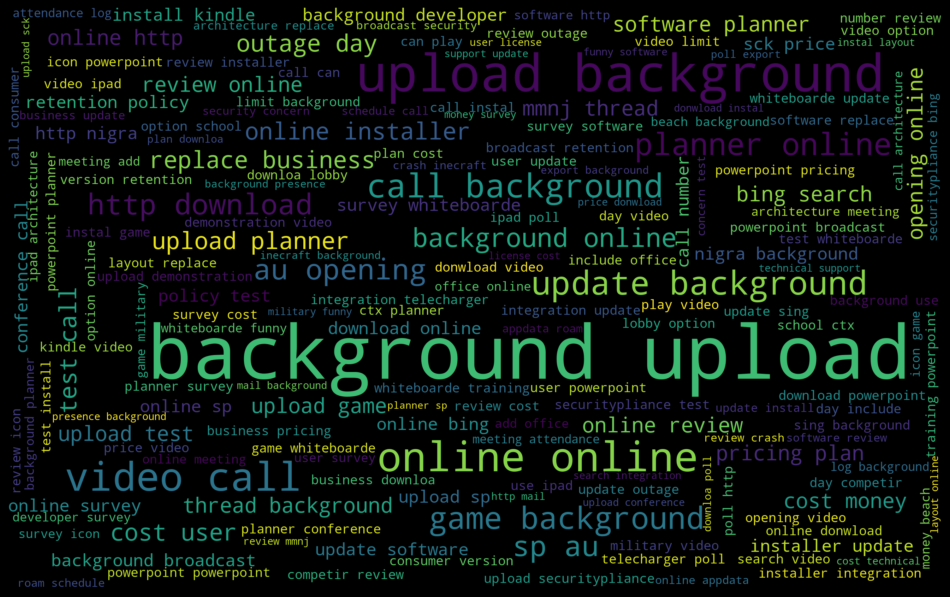

In [125]:
wordcloud(5)

In [335]:
bing_vectors_2[bing_vectors_2['query'].str.contains('best')].head()

0          1         2  cluster  \
159  -4.4897423 -18.244682  9.405348  6         
529  -4.4916730 -18.244326  9.403640  6         
545  -4.4902954 -18.244753  9.404852  6         
1058 -4.4906250 -18.245863  9.404601  6         
1332 -3.0628910  3.919079  -0.193804  9         

                                          query            scrubbed_query  \
159   microsoft teams best practices             good practice              
529   microsoft teams best practices pdf         good practice              
545   microsoft teams best practices             good practice              
1058  microsoft teams best practices             good practice              
1332  microsoft teams governance best practices  governance good practice   

            cluster_name   Feedback_DateTime  
159   Good Practice      2020-01-31 12:00:00  
529   Good Practice      2020-02-29 12:00:00  
545   Good Practice      2020-02-29 12:00:00  
1058  Good Practice      2020-03-31 12:00:00  
1332  Video Conferencing 2020-03-31 12:00:00

In [126]:
cluster_name(6)

[(('turn', 'off'), 368),
 (('best', 'practices'), 192),
 (('quick', 'start'), 160),
 (('on', 'startup'), 144),
 (('a', 'meeting'), 144)]

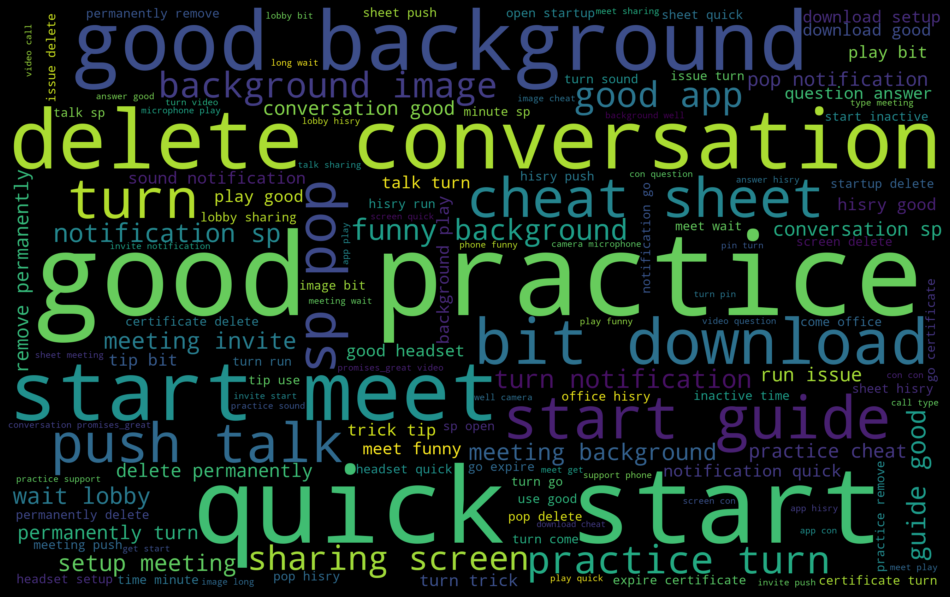

In [127]:
wordcloud(6)

In [215]:
bing_vectors_2[bing_vectors_2['query'].str.contains('virtual')]['query'].value_counts()

microsoft teams virtual background                                                         64
virtual background in microsoft teams                                                      48
at the time of the event, click here to join the virtual session using microsoft teams!    48
virtual background for microsoft teams                                                     48
virtual background microsoft teams                                                         32
virtual backgrounds for microsoft teams                                                    32
add virtual background in microsoft teams                                                  16
microsoft teams virtual consult                                                            16
microsoft teams virtual classroom                                                          16
virtual backgrounds in microsoft teams                                                     16
microsoft teams virtual backgrounds                         

In [237]:
cluster_name(7)

[(('not', 'working'), 224),
 (('delete', 'chat'), 208),
 (('chat', 'hisry'), 208),
 (('virtual', 'background'), 192),
 (('download', 'app'), 160)]

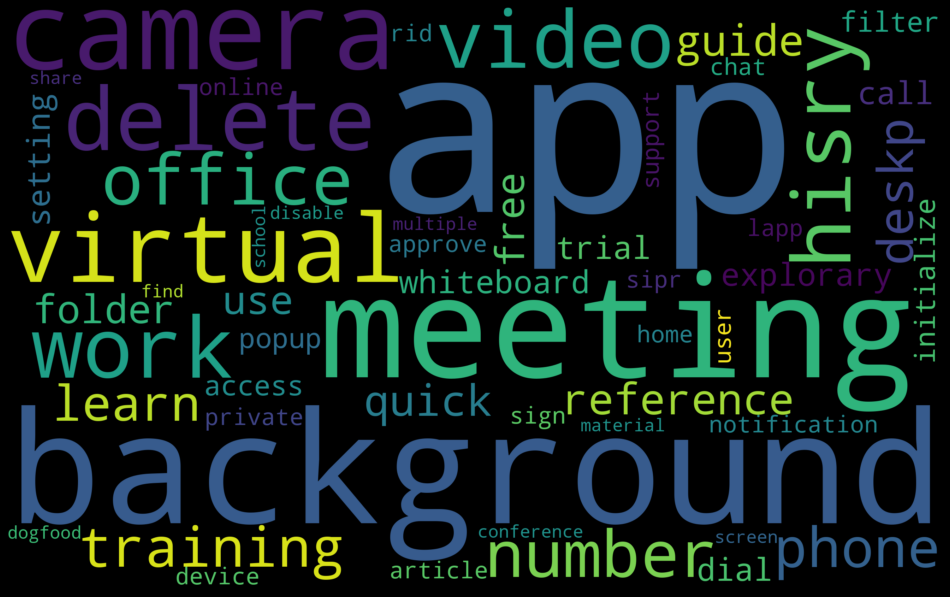

In [247]:
wordcloud(7)

In [204]:
bing_vectors_2[bing_vectors_2['query'].str.contains('share')].head()

0           1          2  cluster  \
73   6.5839887  24.0675050  14.153670  1         
135  9.5529450 -6.2557780  -16.803093  4         
141  9.5528160 -6.2557354  -16.802837  4         
144 -6.0385950 -2.3920715   18.749016  8         
332  9.5532600 -6.2560945  -16.802847  4         

                                  query scrubbed_query  cluster_name  
73   microsoft teams screen share        screen share   Free Install  
135  shared calendar in microsoft teams  share          Windows 10    
141  microsoft teams shared calendar     share          Windows 10    
144  microsoft teams share screen        share screen   Share Screen  
332  microsoft teams shared calendar     share          Windows 10

In [202]:
cluster_name(8)

[(('share', 'screen'), 432),
 (('screen', 'on'), 208),
 (('screen', 'in'), 192),
 (('screen', 'sharing'), 176),
 (('call', 'in'), 176)]

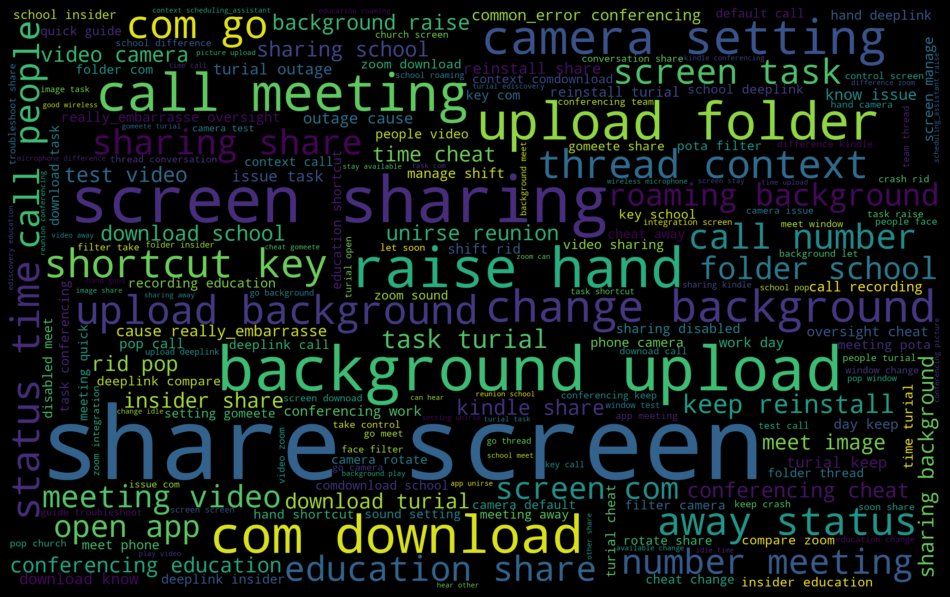

In [203]:
wordcloud(8)

In [132]:
cluster_name(9)

[(('video', 'conferencing'), 240),
 (('background', 'images'), 176),
 (('breakout', 'rooms'), 160),
 (('.', 'online'), 96),
 (('cusmized', 'background'), 80)]

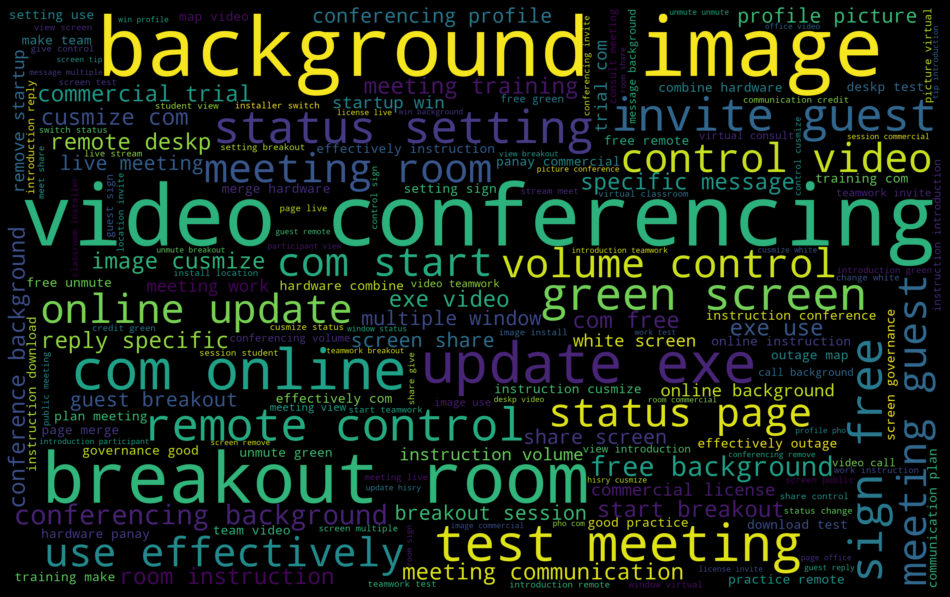

In [133]:
wordcloud(9)

In [134]:
cluster_name(10)

[(('download', 'deskp'), 256),
 (('add', 'background'), 160),
 (('for', 'business'), 144),
 (('//', '..'), 144),
 (('http//./', '?'), 144)]

In [207]:
bing_vectors_2[bing_vectors_2['query'].str.contains('add')].head(20)

0            1           2  cluster  \
100   13.6335380  2.01514550  -17.3570400  2         
149  -3.5010455   12.98923400  7.5137010   10        
176   13.6542230  1.99791360  -17.3774550  2         
366   13.6559610  1.99574660  -17.3810210  2         
564  -1.1229160   15.03951100  13.2507420  10        
645  -0.8022635  -19.43249300  2.9285672   4         
873   13.6790200  1.98997030  -17.3530860  2         
1016  13.6511140  2.00070710  -17.3771270  2         
1043 -12.8629200  12.54731000  13.1581250 -1         
1383  13.6614080  1.98364730  -17.3969040  2         
1472  13.6677210  1.94800160  -17.3197750  2         
1485 -1.1227962   15.03932400  13.2506320  10        
1742  13.6648035  2.00332300  -17.3669720  2         
1880 -9.6811720   15.81647900  4.5557980   10        
1960 -2.2964685   6.83577250  -19.1254000  11        
2141 -1.8602704   0.10684183   2.3449657   4         
2224  13.6607780  1.99601360  -17.3713440  2         
2233 -2.2946777   6.83765900  -19.1236720  11        
2310 -9.6879700   15.82336600  4.5626755   10        
2335  13.6811790  2.00476460  -17.3721900  2         

                                                  query  \
100   microsoft teams outlook add-in                      
149   adding a group to microsoft teams                   
176   how to add microsoft teams to outlook               
366   microsoft teams outlook add-in                      
564   add a guest microsoft teams                         
645   microsoft teams cannot add planner second channel   
873   how to add microsoft teams to outlook               
1016  microsoft teams outlook add-in                      
1043  microsoft teams add in missing from outlook         
1383  add microsoft teams to outlook                      
1472  microsoft teams outlook add in                      
1485  microsoft teams add guest                           
1742  microsoft teams outlook add-in                      
1880  how to add background to microsoft teams            
1960  adding a custom background to microsoft teams       
2141  microsoft teams add ons                             
2224  how to add microsoft teams to outlook               
2233  microsoft teams add custom background               
2310  add background to microsoft teams                   
2335  how to add microsoft teams                          

              scrubbed_query      cluster_name  
100   add                     Camera Sideways   
149   add group               Add Background    
176   add                     Camera Sideways   
366   add                     Camera Sideways   
564   add guest               Add Background    
645   can add planner second  Windows 10        
873   add                     Camera Sideways   
1016  add                     Camera Sideways   
1043  add miss outlook        noise             
1383  add                     Camera Sideways   
1472  add                     Camera Sideways   
1485  add guest               Add Background    
1742  add                     Camera Sideways   
1880  add background          Add Background    
1960  add custom background   Schedule Meeting  
2141  add ons                 Windows 10        
2224  add                     Camera Sideways   
2233  add custom background   Schedule Meeting  
2310  add background          Add Background    
2335  add                     Camera Sideways

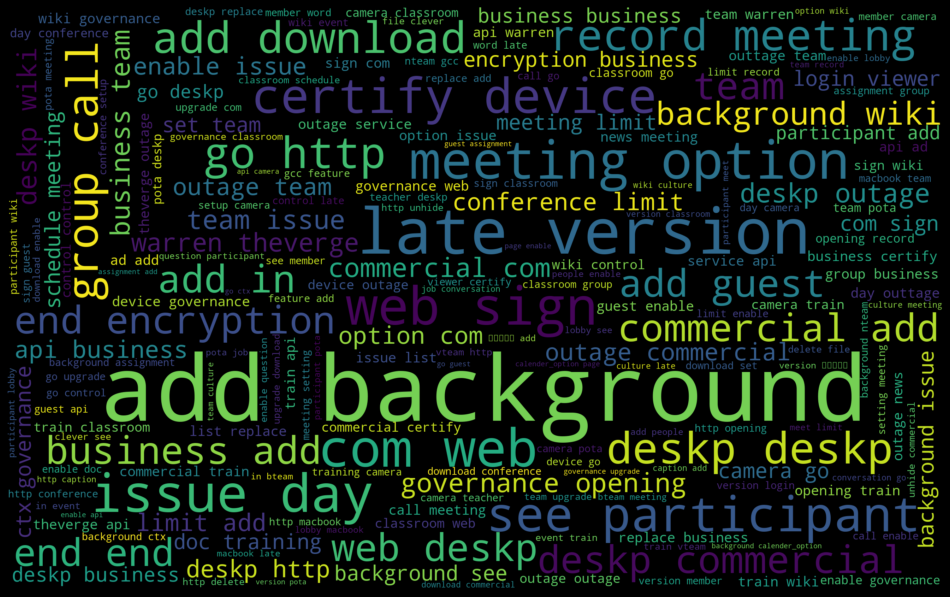

In [135]:
wordcloud(10)

In [136]:
cluster_name(11)

[(('schedule', 'a'), 352),
 (('a', 'meeting'), 352),
 (('schedule', 'meeting'), 224),
 (('meeting', 'in'), 208),
 (('32', 'bit'), 160)]

In [212]:
bing_vectors_2[bing_vectors_2['query'].str.contains('schedule')].head(20)

0           1           2  cluster  \
824   4.1502960  12.6148200 -12.4282360  11        
1298  4.1454377  12.6173050 -12.4254270  11        
1319  4.1535764  12.6061735 -12.4372100  11        
1454  4.1659690  12.5989275 -12.4479380  11        
1641  4.1392470  12.6153470 -12.4187900  11        
1804  4.1469250  12.6179790 -12.4251740  11        
1919  4.1447530  12.6141880 -12.4233265  11        
2420  4.1447706  12.6135790 -12.4234560  11        
2490  4.1320887  12.6307790 -12.4112170  11        
2638  4.1873336  12.6573960 -12.3854220  11        
2816  4.1906676  12.6532340 -12.3901210  11        
2827  4.1502953  12.6328410 -12.4106460  11        
3072 -8.3941030  18.2753680 -0.3891710   10        
3083  4.1484747  12.6143070 -12.4276750  11        
3275  4.1483580  12.6151760 -12.4276470  11        
3335  4.1452400  12.6189785 -12.4216970  11        
3342  4.1787233  12.5847990 -12.4569220  11        
3418  4.1152070  12.5793320 -12.4604480  11        
3469  4.1533713  12.6191370 -12.4229050  11        
3508  4.1575313  12.6126470 -12.4325230  11        

                                               query         scrubbed_query  \
824   how to schedule a meeting in microsoft teams    schedule meeting        
1298  how to schedule a microsoft teams meeting       schedule meeting        
1319  microsoft teams schedule a meeting              schedule meeting        
1454  microsoft teams schedule meeting                schedule meeting        
1641  how to schedule a meeting in microsoft teams    schedule meeting        
1804  how to schedule a microsoft teams meeting       schedule meeting        
1919  microsoft teams schedule a meeting              schedule meeting        
2420  schedule a meeting in microsoft teams           schedule meeting        
2490  how to schedule meeting in microsoft teams      schedule meeting        
2638  schedule meeting in microsoft teams             schedule meeting        
2816  schedule a microsoft teams meeting              schedule meeting        
2827  how to schedule meetings in microsoft teams     schedule meeting        
3072  microsoft teams schedule meeting for team       schedule meeting team   
3083  microsoft teams schedule meeting                schedule meeting        
3275  how do i schedule a meeting in microsoft teams  schedule meeting        
3335  schedule meeting with microsoft teams           schedule meeting        
3342  how to schedule microsoft teams meeting         schedule meeting        
3418  microsoft teams how to schedule a meeting       schedule meeting        
3469  how do i schedule microsoft teams meeting?      schedule meeting        
3508  how to schedule a meeting on microsoft teams    schedule meeting        

          cluster_name  
824   Schedule Meeting  
1298  Schedule Meeting  
1319  Schedule Meeting  
1454  Schedule Meeting  
1641  Schedule Meeting  
1804  Schedule Meeting  
1919  Schedule Meeting  
2420  Schedule Meeting  
2490  Schedule Meeting  
2638  Schedule Meeting  
2816  Schedule Meeting  
2827  Schedule Meeting  
3072  Add-Ins           
3083  Schedule Meeting  
3275  Schedule Meeting  
3335  Schedule Meeting  
3342  Schedule Meeting  
3418  Schedule Meeting  
3469  Schedule Meeting  
3508  Schedule Meeting

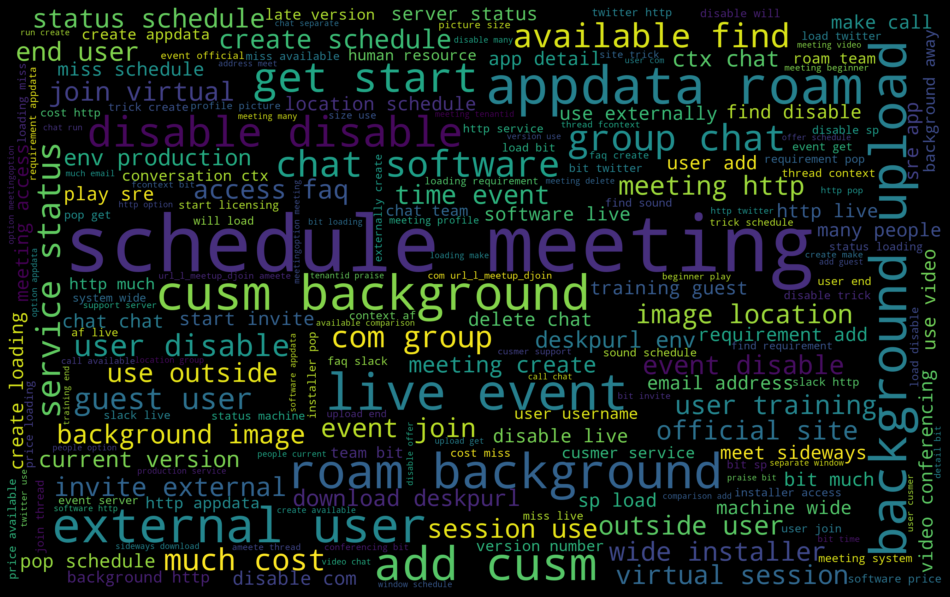

In [137]:
wordcloud(11)

In [ ]:
#Now I want to use UMAP to visualize the clusters, so I am going to be using the full vectors and reduce them again -- 
#setting min_dist higher so that we can separate points more
reducer_2 = umap.UMAP(n_neighbors=200, n_components = 3, min_dist = .25)
reduced_vectors_2 = reducer_2.fit_transform(bing)

In [ ]:
reduced_vectors_2['cluster'] = [x for x in cluster_labels]

In [320]:
#bing.to_csv('bing_queries_final_clusters.csv')

In [209]:
cluster_names = []
for x in bing_vectors_2['cluster']:
    
    if x == 0:
        
        cluster_names.append('Sign In')
        
    elif x == 1:
        
        cluster_names.append('Free Install')
        
    elif x == 2:
        
        cluster_names.append('Camera Sideways')
        
    elif x == 4:
        
        cluster_names.append('Windows 10')
        
    elif x == 5:
        
        cluster_names.append('Background Upload')
        
    elif x == 6:
        
        cluster_names.append('Good Practice')
        
    elif x == 7:
        
        cluster_names.append('Not Working')
        
    elif x == 8:
        
        cluster_names.append('Share Screen')
        
    elif x == 9:
        
        cluster_names.append('Video Conferencing')
        
    elif x == 10:
        
        cluster_names.append('Add-Ins')
        
    elif x == 11:
        
        cluster_names.append('Schedule Meeting')
        
    elif x == -1:
        
        cluster_names.append('noise')
        
    else:
        
        cluster_names.append(x)
        
bing_vectors_2['cluster_name'] = [x for x in cluster_names]

In [210]:
bing_vectors_2.head()

0          1          2  cluster  \
0  30.866621  9.5091830  8.7188050  1         
1 -11.944756  4.6597220  2.2510730  9         
2  13.973702  2.6014721  3.5440943  3         
3 -9.156345  -6.1814460 -2.2882104  7         
4 -20.415802  5.7526810  7.1407866  5         

                                           query     scrubbed_query  \
0  install microsoft teams                        install             
1  teams.microsoft.com online                     com online          
2  teams microsoft download                       NaN                 
3  download microsoft teams app for desktop       app desktop         
4  how to stop microsoft teams from auto opening  stop auto opening   

         cluster_name  
0  Free Install        
1  Video Conferencing  
2  3                   
3  Not Working         
4  Background Upload

In [401]:
bing_vectors_2.to_csv('final_teams_bing_clustering_results.csv', index = False)

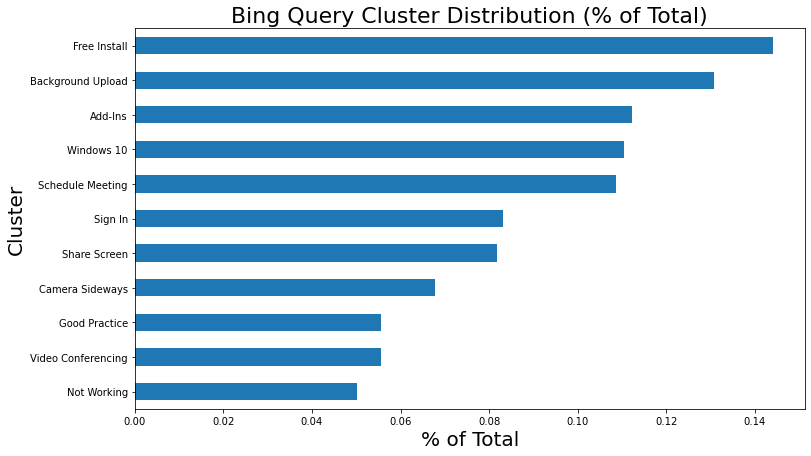

In [211]:
bing_vectors_2[(bing_vectors_2['cluster_name'] != 3) & (bing_vectors_2['cluster_name'] != 'noise')]['cluster_name']\
.value_counts(normalize = True).sort_values().plot(kind = 'barh', figsize = (12, 7))
plt.title('Bing Query Cluster Distribution (% of Total)', fontsize = 22)
plt.xlabel('% of Total', fontsize = 20)
plt.ylabel('Cluster', fontsize = 20);

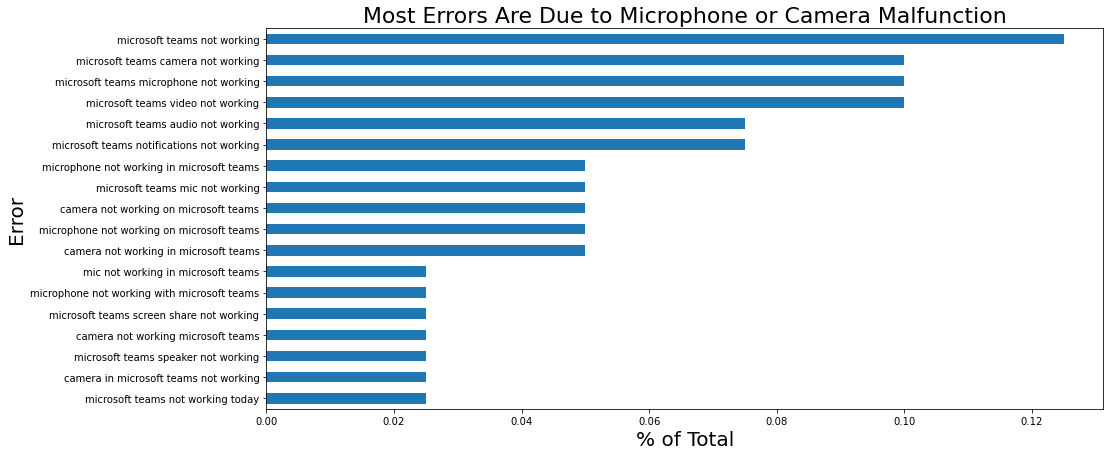

In [201]:
bing_vectors_2[bing_vectors_2['query'].str.contains('not working')]['query'].value_counts(normalize = True).sort_values().plot(kind = 'barh', figsize = (15, 7))
plt.title("Most Errors Are Due to Microphone or Camera Malfunction", fontsize = 22)
plt.xlabel('% of Total', fontsize = 20)
plt.ylabel('Error', fontsize = 20);

In [232]:
from transformers import pipeline

nlp = pipeline("sentiment-analysis")

result = nlp("Cumbersome, massive memory utilization. Unintuitive... I want one client to do all of communicaiton. Can Outlook and Teams be merged?")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

In [230]:
result['label']

'POSITIVE'

In [296]:
bing_vectors_2['Feedback_DateTime'] = pd.to_datetime(bing_vectors_2['Feedback_DateTime'])

In [308]:
cluster_trends = pd.DataFrame(bing_vectors_2.groupby(bing_vectors_2['Feedback_DateTime'].dt.month).cluster_name.value_counts()).rename(columns = {'cluster_name':'count'}).reset_index()

In [315]:
cluster_trends = cluster_trends[(cluster_trends['cluster_name'] != 3) & (cluster_trends['cluster_name'] != 'noise')]

In [318]:
cluster_trends['Feedback_DateTime'] = cluster_trends['Feedback_DateTime'].map({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June'})

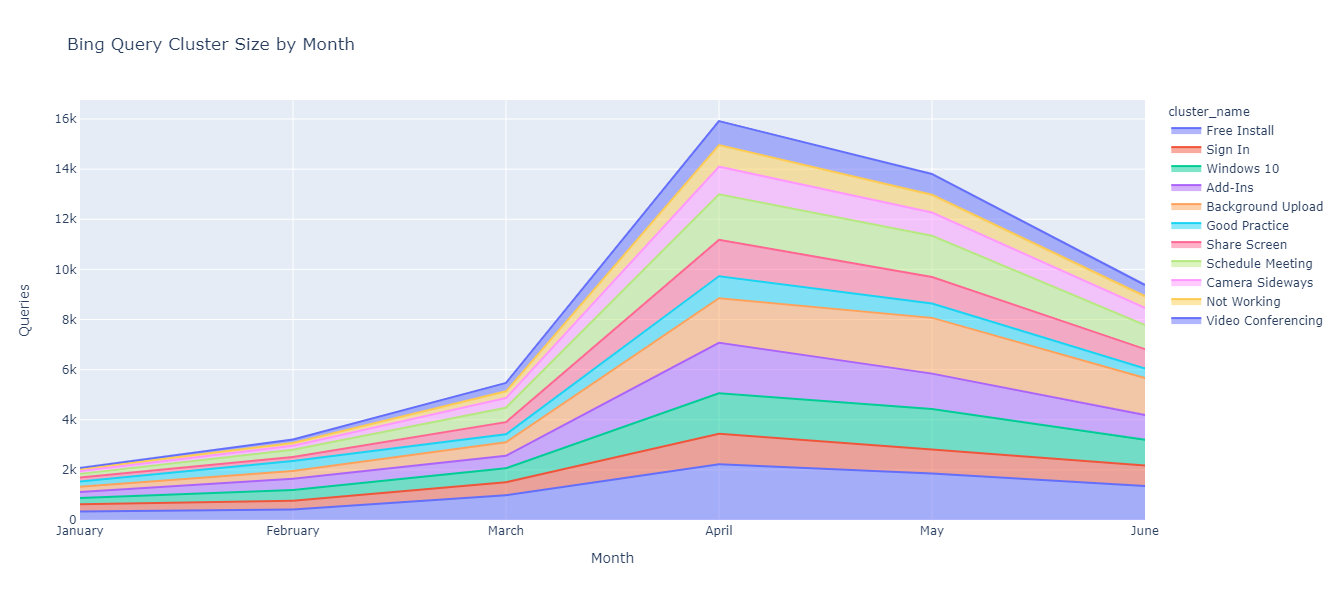

In [336]:
fig = px.area(cluster_trends, x="Feedback_DateTime", y="count", color="cluster_name",
	      line_group="cluster_name", labels = {'Feedback_DateTime':'Month', 'count':'Queries'}, width = 1100, height = 600, title = 'Bing Query Cluster Size by Month')
# fig.update_layout(
#     title={
#         'text': "Bing Query Cluster Trends",
#         'y':0.9,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
fig.show()